# RADIO INTERFEROMETRY AT X BAND

In [18]:
%matplotlib inline
#%matplotlib notebook
import numpy as np
from matplotlib import pyplot
from astropy import units as u, constants as c
import ugradio
import astropy
from ugradio import timing
from ugradio import doppler
from ugradio import nch

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import cmath

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from pylab import rcParams
rcParams["axes.linewidth"]  = 2
rcParams["font.size"]  = 14

%config InlineBackend.figure_format = 'retina'

#Tick formatting
from matplotlib.ticker import MultipleLocator

# Figure Insets
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

import matplotlib as mpl
#mpl.style.use('seaborn')

In [19]:
def scale(data, volt_range):
    """
    Rescales sampler data.
    
    Parameters:
    data (array) : data to be rescaled
    volt_range (double) : volt range input parameter 
    
    Returns:
    output (array) : rescaled data
    """
    
    output = (data * volt_range) / np.power(2, 15) / 2 # factor of 2
    return output

def load(filename, volt_range, nblocks, nsamples = 16000):
    """
    Loads a file with collected data. 
    
    Parameters:
    filename (string) : name of the file
    volt_range (double) : volt range input parameter
    nblocks (int) : number of data blocks
    
    Returns:
    complex (array) : rescaled data, split by block
    real (array) : real component
    imag (array) : imaginary component
    """
    
    data = np.load(filename)
    scaled = scale(data, volt_range)
    split = np.split(scaled, 2)
    real = split[0]
    imag = split[1]
    real_split = np.split(real, nblocks)
    imag_split = np.split(imag, nblocks)
    output = []
    for i in range(0, nblocks):
        output.append(real_split[i] + 1j * imag_split[i])
    return output, real, imag

def get_pwr(signal, v_samp, nsamples):
    """
    Returns the power spectrum of a given signal as a function of frequency.
    
    Parameters:
    signal (array) : signal data
    v_samp (double) : sampling frequency
    nsamples (int) : number of samples per block
    
    Returns: 
    power (array) : power spectrum
    freqs (array) : frequencies
    """
    
    nblocks = len(signal)
    power = []
    for i in range(0, nblocks):
        ft = np.fft.fft(signal[i])
        power.append(np.abs(ft) ** 2)
    dt = 1 / v_samp
    freqs = np.fft.fftfreq(nsamples, d = dt)
    
    return freqs, power

def avg_smooth(data, freqs, nsmooth):
    """
    Smooths data by taking averages over bins of a specified size.
    
    Parameters:
    data (array) : data to be smoothed
    freqs (array) : frequencies
    nsmooth (int) : number of bins
    """
    
    data_split = np.split(data, nsmooth)
    freqs_split = np.split(freqs, nsmooth)
    data_smooth = []
    freqs_smooth = []
    for i in range(0, nsmooth):
        data_smooth.append(np.mean(data_split[i], axis = 0))
        freqs_smooth.append(np.mean(freqs_split[i], axis = 0))
    return data_smooth, freqs_smooth

def med_smooth(data, freqs, nsmooth):
    """
    Smooths data by taking means over bins of a specified size.
    
    Parameters:
    data (array) : data to be smoothed
    freqs (array) : frequencies
    nsmooth (int) : number of bins
    """
    
    data_split = np.split(data, nsmooth)
    freqs_split = np.split(freqs, nsmooth)
    data_smooth = []
    freqs_smooth = []
    for i in range(0, nsmooth):
        data_smooth.append(np.median(data_split[i], axis = 0))
        freqs_smooth.append(np.median(freqs_split[i], axis = 0))
    return data_smooth, freqs_smooth

ifm = ugradio.interf.Interferometer() #provides an interface for controlling
                                    #the pointing of the two telescopes that constitute the interferometer.
    
ifm.stow() #points the telescopes to the zenith. This minimizes
            #wind drag to help keep the telescope from being destroyed by strong winds.
            #When no-one is using the telescope, it should be stowed. Please stow the
            #telescope when you are not using it!
            
ifm.maintenance() #points the telescope to ’maintenance position’ to
                    #facilitate working on the feed. alt=20, az=180.
    
ifm.get_pointing() #returns both telescopes’ current alt, az.

ifm.point(alt,az) #points telescopes to specified alt, az.
                    #It can take bit for the telescopes to move, so be patient until this
                    #command returns.
        
hpm = ugradio.hp_multi.HP_Multimeter() #provides an interface for reading
                                        #the voltage output of the interferometer.
    
hpm.read_voltage() #reads once from the HP Multimeter.

hpm.start_recording(dt) #reads from the voltage every dt seconds, indefinitely.
                        #Data are stored in a buffer inside of hpm.
    
hpm.get_recording_data() #reads out all the voltages (and timestamps) that
                        #have been acquired since start_recording was called. NOTE: to avoid losing
                        #your data for a long observation, you should periodically call this function
                        #3and save the data to disk, just in case your observing script errors out.

hpm.end_recording() #terminates the recording.

ugradio.coord.sunpos(jd) #returns the ra/dec of the Sun at the specified jd.

ugradio.coord.moonpos(jd,lat,lon,alt) #returns the ra/dec of the Moon at
                                        #the specified jd relative to the specified observing lat, lon, and alt.
                                        #Note that because the Moon is close to the Earth, it has a noticeable
                                        #parallax that makes its ra/dec depend on where you are. This takes that
                                        #into account.
                
ugradio.coord.get_altaz(ra, dec, jd, lat, lon, alt) #returns the alt/az
                                                    #of the specified ra/dec coordinate for the specified lat/lon/alt and
                                                    #observing time. Use the ’equinox’ variable to specify the coordinate
                                                    #system on the input ra/dec parameters.
            
ugradio.coord.precess(ra, dec, jd, equinox) #returns the precessed ra/dec
                                            #for the ra/dec catalog coordinate with given ’equinox’ specifing the coordinate
                                            #system on the input ra/dec parameters.

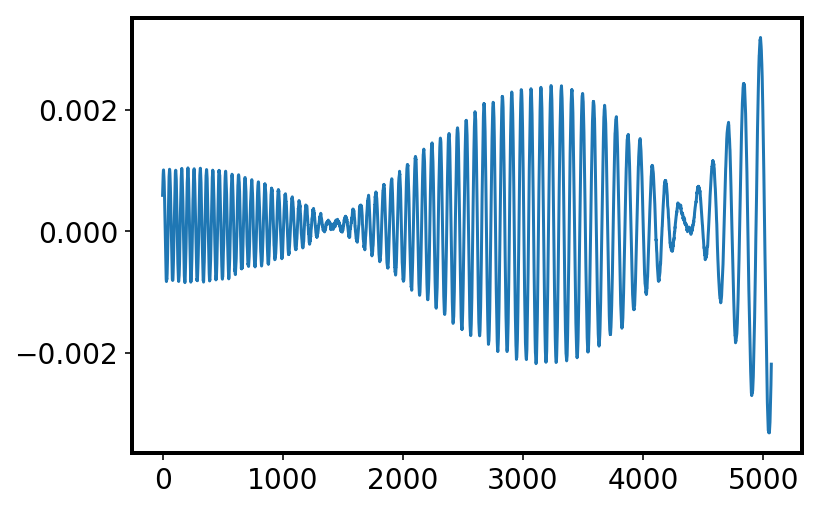

<Figure size 432x288 with 0 Axes>

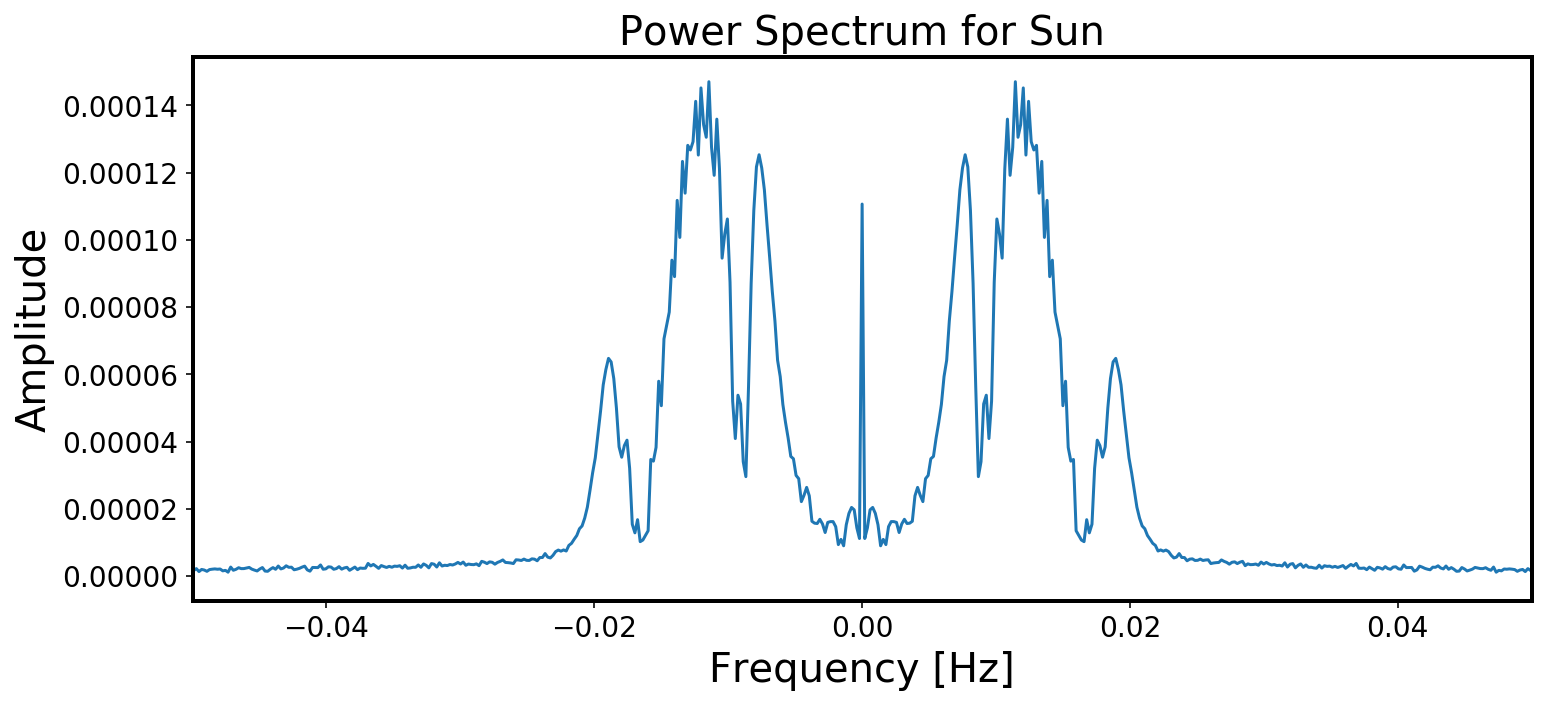

/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


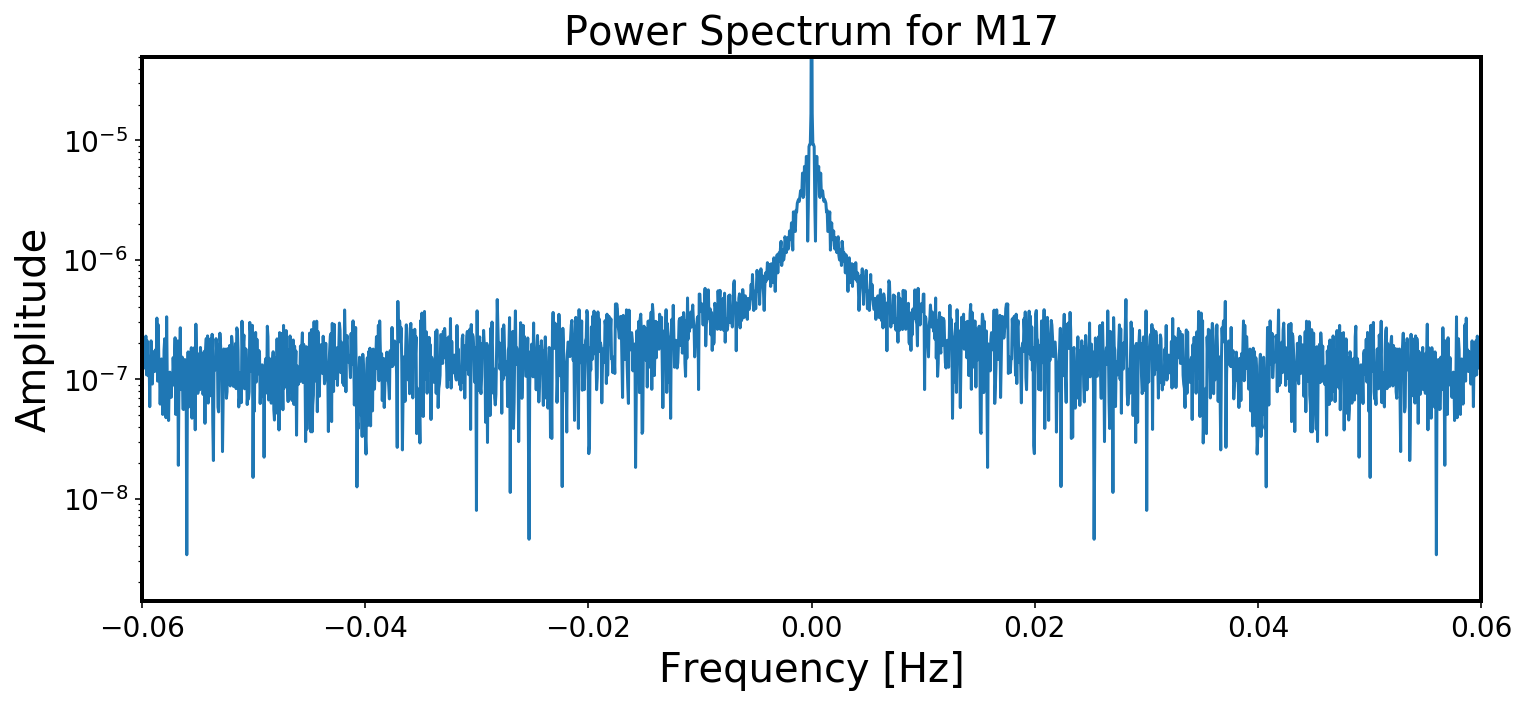

(5069, 1)


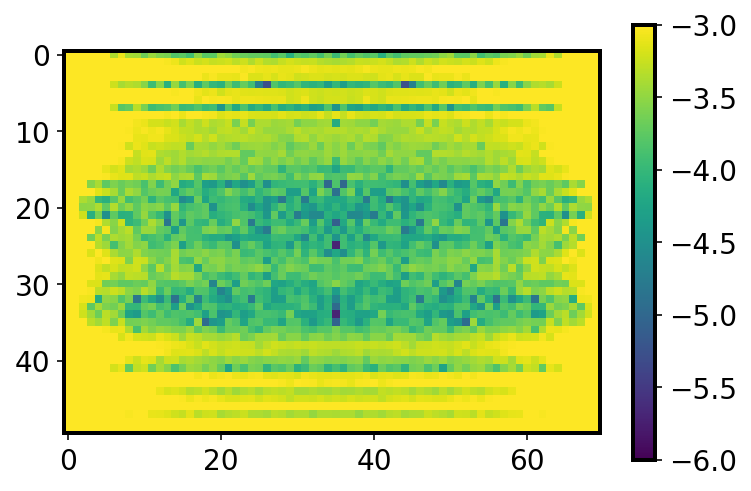

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [20]:

data = np.load('sun_data(3).npz')
plt.plot(data['volts'])
plt.show()
plt.figure()


from scipy.fftpack import fft, fftfreq, fftshift
# number of signal points
N = len(data['volts'])
# sample spacing
T = 1.0 
x = np.linspace(0.0, N*T, N)
y = data['volts']
yf = fft(y)
xf = fftfreq(N, T)
xf = fftshift(xf)
yplot = fftshift(yf)
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (12, 5))
plt.plot(xf, 1.0/N * np.abs(yplot))
plt.title("Power Spectrum for Sun",size=20)
plt.ylabel('Amplitude',size=20)
plt.xlabel('Frequency [Hz]',size=20)
#plt.ylim(0,.000001)
plt.xlim(-.05,.05)
#plt.savefig('sun.png', dpi = 1200)
plt.show()



m17data = np.load('M17_data.npz')

from scipy.fftpack import fft, fftfreq, fftshift
# number of signal points
N = len(m17data['volts'])
# sample spacing
T = 1.0 
x = np.linspace(0.0, N*T, N)
y = m17data['volts']
yf = fft(y)
xf = fftfreq(N, T)
xf = fftshift(xf)
yplot = fftshift(yf)
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (12, 5))
plt.semilogy(xf, 1.0/N * np.abs(yplot))
plt.title("Power Spectrum for M17",size=20)
plt.ylabel('Amplitude',size=20)
plt.xlabel('Frequency [Hz]',size=20)
plt.ylim(0,.00005)
plt.xlim(-.06,.06)
#plt.savefig('m17.png', dpi = 1200)
plt.show()





d = data['volts']
d.shape=(-5,1)
print(d.shape)

_d = np.fft.fft(d,axis=1)
_davg = np.average(np.abs(_d)**2,axis=0)


d.shape=(-1,)
d = d[:3500]
d.shape = (50,-1)
_d = np.fft.fft(d,axis=1)

plt.imshow(np.log10(np.abs(_d)),vmax=-3,vmin=-6,interpolation='nearest')
plt.colorbar()
plt.show()
plt.figure()



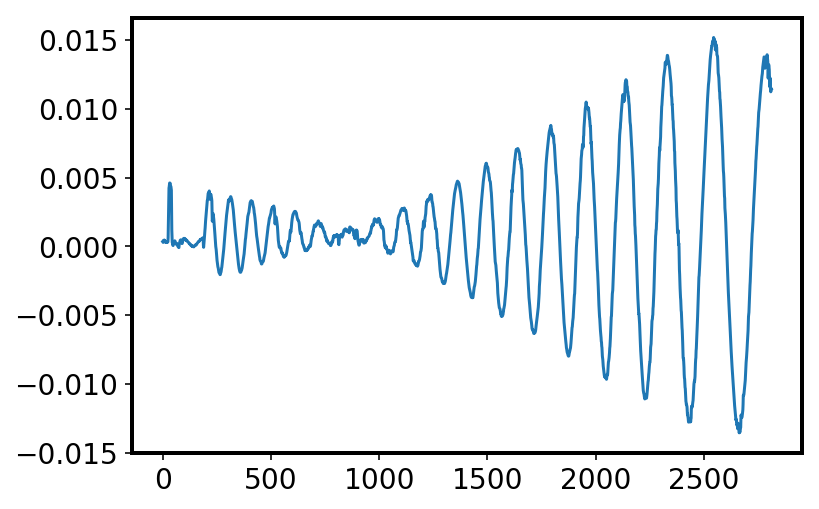

In [21]:

sun = np.load('sun_data557.npz')
plt.plot(sun['volts'])

In [22]:
data = np.load('M17_final.npz.npz')
time = data['times']
print(len(time))

ugradio.timing.local_time(time[0])

IOError: [Errno 2] No such file or directory: 'M17_final.npz.npz'

In [23]:
L = 37.873199 * u.deg
nu = 10.7 * u.GHz

data = np.load('M17_final.npz')
orion_volts = data['volts'] - data['volts'].mean()
orion_LST   = data['times']

In [24]:
def hour_angle(LST, alpha):
    """Get the local hour angle of a target.
    
    Parameters
    ----------
    LST : (Quantity <float, degrees or radians>)
    
    Local Sideral Time
    
    alpha : (Quantity <float, degrees or radians>)
    Right Ascnesion of the target
    
    Note: Parameters can be arrays of the same size.
    
    Returns
    -------
    
    array of Quantity <float, degrees>
    Hour angle
    
    """
    #is_angle(LST)
    #is_angle(alpha)

    hs = (LST - alpha)#.to(u.deg)
    
    return constrain_angle_to_one_circle(hs)

def is_angle(x):
    is_Quantity(x)
    assert (x.unit == u.deg or x.unit == u.rad), 'unit != degree or radian'

from astropy.units.quantity import Quantity
def is_Quantity(x):
    assert (type(x) == Quantity), 'type != astropy.units.quantity.Quantity'

def constrain_angle_to_one_circle(angle):
    """Constrain an angle to be between 0 and 360 degrees (or equivalent radians).
    Ex: -10degrees -> 350degrees.
    
    
    Parameters
    ----------
    angle : (Quantity <float, degrees or radians>)
    
    Returns
    -------
    (Quantity <float, degrees or radians>)
    return has same units as input
    """
    
    #is_angle(angle)
    
    circle = 360 
    
    constrain = x % circle
    
    
    return (angle)  

def get_polyfit(x,y,degree = 1):
    """TODO: DOCSTRING"""
    p = np.polyfit(x, y, degree)
    return  np.polyval(p, x)


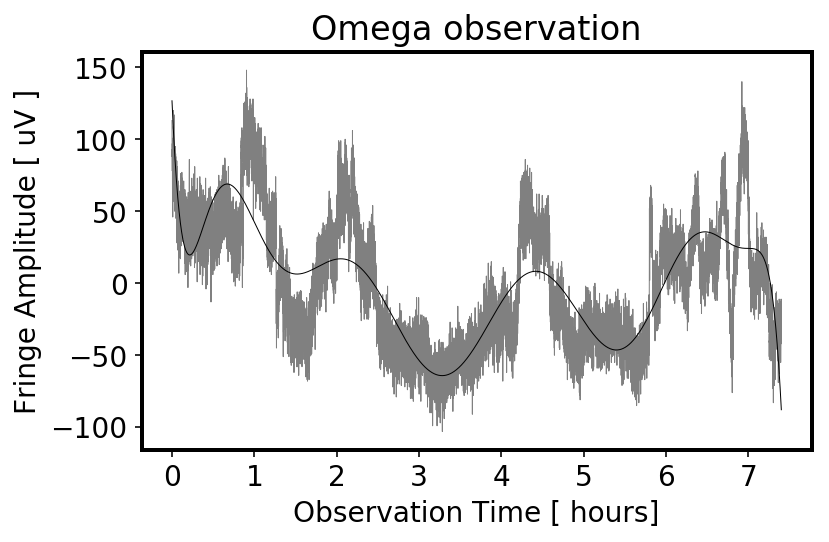

In [25]:
orion_ra = 275.1111111 #* u.deg
orion_dec = -16.1766777777 #* u.deg

dt = 1 * u.s # sample rate
orion_seconds = np.arange(len(orion_volts)) * dt
orion_ha = hour_angle(orion_LST, orion_ra)

orion_polyfit = get_polyfit(orion_seconds, orion_volts, degree = 12)

orion_plot_hour_angles_degrees = constrain_angle_to_one_circle((np.arange(0,150, 15) - 60) * u.deg).value


    
    
fig, ax = plt.subplots()
ax.plot(orion_seconds, orion_volts * 1000 * 1000, linewidth = 0.5, color = 'gray')
ax.plot(orion_seconds, orion_polyfit * 1000 * 1000, linewidth = 0.5, color = 'black')
ax.set_ylabel('Fringe Amplitude [ uV ]')

xtick_locations = np.arange(0,len(orion_volts), 3600)
xtick_labels = [str(int(x)) for x in  xtick_locations / 3600]
ax.set_xticks(xtick_locations)
ax.set_xticklabels(xtick_labels)
ax.set_xlabel('Observation Time [ hours]')


#xticktop_locations = orion_seconds.value[xticktop_locations_ha_indices]
xticktop_labels = [str(int(x)) for x in  orion_plot_hour_angles_degrees]

ax.set_title('Omega observation', y = 1)
plt.tight_layout()
plt.savefig('omega_1.pdf', dpi = 1200)
plt.show()

In [26]:

adjusted_orion_volts = orion_volts - orion_polyfit

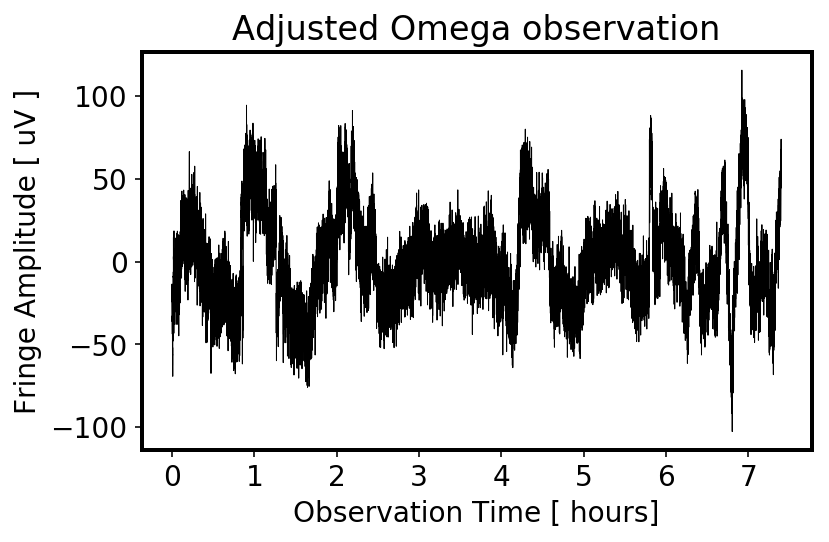

In [27]:
fig, ax = plt.subplots()
ax.plot(orion_seconds, adjusted_orion_volts * 1000 * 1000, linewidth = 0.5, color = 'black')
ax.set_ylabel('Fringe Amplitude [ uV ]')

xtick_locations = np.arange(0,len(orion_volts), 3600)
xtick_labels = [str(int(x)) for x in  xtick_locations / 3600]
ax.set_xticks(xtick_locations)
ax.set_xticklabels(xtick_labels)
ax.set_xlabel('Observation Time [ hours]')


ax.set_title('Adjusted Omega observation', y = 1)
plt.tight_layout()
plt.savefig('omega_2.png', dpi = 1200)
plt.show()

In [28]:
def S_mins_image(Q_ns_range, Q_ew_range, ha, b, filename = None):
    
    num_Q = len(Q_ns_range)
    S_2D = np.zeros((num_Q, num_Q))
    
    # compute minimums
    for i in range(num_Q):#ns
        for j in range(num_Q):#ew
            M = fringe_amplitude_fit_matrix(ha, Q_ew_range[j], Q_ns_range[i])
            x = solve_x(M,b)
            fit = fringe_amplitude_fit(M,x)
            S_2D[i, j] = sum_squared_residuals(b,fit)
            sys.stdout.write('\r'+str('%d, %d' %(i,j) ))
    # show plot       
    plt.imshow(np.log10(S_2D), cmap = 'gray')
    plt.xlabel('Q_ew indices')
    plt.ylabel('Q_ns indices')
    plt.title('S(Q_ns,Q_ew,ha)')
    plt.colorbar()
    plt.show()
    
    if filename != None:
        np.savez(filename, S_2D)
    
    # return Q values of minimium
    return argmin_2D(S_2D)

In [29]:
def Q_to_baseline(Q_mins, Q_ns_range, Q_ew_range):
    Q_min_ns = Q_ns_range[Q_mins[0]]
    Q_min_ew = Q_ew_range[Q_mins[1]]
    
    print(B_ns(orion_dec, Q_min_ns))
    print(B_ew(orion_dec, Q_min_ew))

In [30]:
b = np.matrix(adjusted_orion_volts).T

In [31]:
num_Q = 100
Q_ns_bounds0 = [Q_ns(orion_dec,B_ns = 1e-3 * u.m), Q_ns(orion_dec,B_ns = 5 * u.m)]
Q_ew_bounds0 = [Q_ew(orion_dec,B_ew = 10 * u.m), Q_ew(orion_dec,B_ew = 30 * u.m)]

Q_ns_range0 = np.linspace(Q_ns_bounds0[0], Q_ns_bounds0[1], num_Q)
Q_ew_range0 = np.linspace(Q_ew_bounds0[0], Q_ew_bounds0[1], num_Q)

# mins0 = S_mins_image(Q_ns_range0, Q_ew_range0, orion_ha, b, filename = 'S2_bounds0')
# Q_to_baseline(mins0,  Q_ns_range0, Q_ew_range0)

NameError: name 'Q_ns' is not defined

In [32]:
num_Q0 = 100
Q_ns_bounds1 = [Q_ns_range0[20], Q_ns_range0[40]]
Q_ew_bounds1 = [Q_ew_range0[10], Q_ew_range0[30]]

Q_ns_range1 = np.linspace(Q_ns_bounds1[0], Q_ns_bounds1[1], num_Q0)
Q_ew_range1 = np.linspace(Q_ew_bounds1[0], Q_ew_bounds1[1], num_Q0)

NameError: name 'Q_ns_range0' is not defined

In [33]:
num_Q = 100
Q_ns_bounds2 = [Q_ns_range1[30], Q_ns_range1[60]]
Q_ew_bounds2 = [Q_ew_range1[60], Q_ew_range1[75]]

Q_ns_range2 = np.linspace(Q_ns_bounds2[0], Q_ns_bounds2[1], num_Q)
Q_ew_range2 = np.linspace(Q_ew_bounds2[0], Q_ew_bounds2[1], num_Q)

NameError: name 'Q_ns_range1' is not defined

In [34]:
num_Q = 100
Q_ns_bounds3 = [Q_ns_range2[20], Q_ns_range2[60]]
Q_ew_bounds3 = [Q_ew_range2[30], Q_ew_range2[55]]

Q_ns_range3 = np.linspace(Q_ns_bounds3[0], Q_ns_bounds3[1], num_Q)
Q_ew_range3 = np.linspace(Q_ew_bounds3[0], Q_ew_bounds3[1], num_Q)

NameError: name 'Q_ns_range2' is not defined

In [35]:
mins3 = [46, 58]

In [36]:
Q_ns_star = Q_ns_range3[mins3[0]]
Q_ew_star = Q_ew_range3[mins3[1]]

Delta_Q_ns_arr = Q_ns_range3 - Q_ns_star
Delta_Q_ew_arr = Q_ew_range3 - Q_ew_star

NameError: name 'Q_ns_range3' is not defined

In [37]:
Q_ns_star

NameError: name 'Q_ns_star' is not defined

In [38]:
Q_ew_star

NameError: name 'Q_ew_star' is not defined

In [39]:
B_ew_val = B_ew(orion_dec,Q_ew_star)
print(B_ew_val)

B_ns_val = B_ns(orion_dec,Q_ns_star)
print(B_ns_val)

NameError: name 'B_ew' is not defined

In [40]:
for i in range(len(Delta_Q_ns_arr) - 2):
    for j in range(len(Delta_Q_ew_arr) - 2):
        
        y = delta_S2_arr[i,:]
        x = Delta_Q_ew_arr
        
        dy = np.diff(y,1)
        dx = np.diff(x,1)
        
        yfirst = dy/dx
        partial_s2_partial_Q_ew_first[i,:] = yfirst
        
        xfirst = 0.5*(x[:-1]+x[1:])
        partial_s2_partial_Q_ew_first_xvals[i,:] = xfirst
        
        dyfirst = np.diff(yfirst,1)
        dxfirst = np.diff(xfirst,1)
        
        ysecond = dyfirst/dxfirst
        partial_s2_partial_Q_ew_second[i,:] = ysecond
        
        xsecond = 0.5*(xfirst[:-1]+xfirst[1:])
        partial_s2_partial_Q_ew_second_xvals[i,:] = xsecond

NameError: name 'Delta_Q_ns_arr' is not defined

In [41]:
import sys
orion_window_len = 1200 #seconds
orion_remainder = int(len(orion_volts) % orion_window_len)

orion_short_volts = orion_volts[:-orion_remainder]
orion_short_times = orion_volts[:-orion_remainder]

orion_VLA = np.zeros((len(orion_short_volts) - orion_window_len , orion_window_len))
for i in range(len(orion_short_volts) - orion_window_len):
    orion_window = orion_short_volts[i: orion_window_len + i]
    orion_VLA[i,:] = np.fft.fftshift(np.abs(np.fft.fft(orion_window))**2)
    sys.stdout.write('\r'+str('%d' %i ))

25199

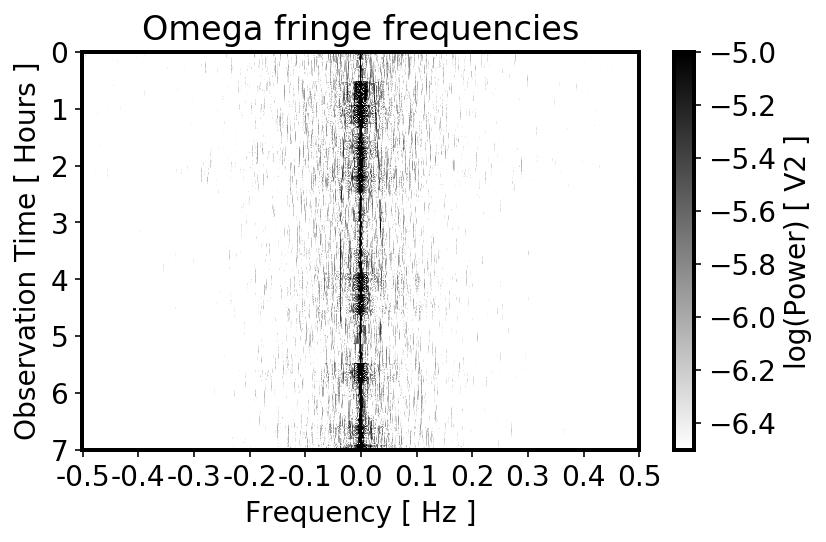

In [42]:
orion_no_dc_min_max  = np.copy(orion_VLA)

for i in range(orion_no_dc_min_max.shape[0]):
    orion_no_dc_min_max[i][595:605] = np.mean(orion_no_dc_min_max[i][0:300])

plt.imshow(np.log10(orion_VLA), aspect = 'auto',
           cmap = 'binary',
           interpolation='none', vmax=-5, vmin=-6.5)

ytick_locations = np.arange(0,orion_VLA.shape[0] + orion_window_len)[::orion_window_len][::3]
ytick_labels = [str(int(x)) for x in  np.arange(0,orion_VLA.shape[0] + orion_window_len)[::orion_window_len][::3] / 3600]
plt.yticks(ytick_locations, ytick_labels)
plt.ylabel('Observation Time [ Hours ]')

xtick_locations = np.arange(0,orion_window_len + orion_window_len/10)[::60][0::2]
freqs = np.round(np.fft.fftshift(np.fft.fftfreq(orion_window_len))[::60], decimals = 2)[0::2]
xtick_labels = np.append(freqs, abs(freqs[0]))
plt.xticks(xtick_locations, xtick_labels)
plt.xlabel('Frequency [ Hz ]')

cbar = plt.colorbar()
cbar.set_label('log(Power) [ V2 ]')
plt.title('Omega fringe frequencies')
plt.tight_layout()
plt.savefig('EYE.pdf', dpi = 1200)
plt.show()

In [43]:
def peak_finder(signal, threshold):

    peaks = [] #x positions of the peaks, or rather, their index

    for i in range(2,len(signal)-2):

        if signal[i - 2] < signal[i] and signal[i - 1] < signal[i]and signal[i] > signal[i + 1] and signal[i] > signal[i + 2]: #four
                                    #conditions to be a peak (see description)
            if signal[i] > threshold: #is the value of the spectrum at i higher than our
                            #threshold?

                peaks.append(i)
    return peaks

In [44]:
orion_peaksVLA = np.zeros((orion_no_dc_min_max.shape[0], 2))
    
for i in range(orion_no_dc_min_max.shape[0]):
    sys.stdout.write('\r'+str('%d' %i ))
    
    orion_threshold_delta = 0
    num_peaks = 0
    counter = 0
    while(True):
        if counter == 20:
            peaks = [0,0]
            break
        orion_threshold = orion_no_dc_min_max[i].max() - orion_threshold_delta
#         sys.stdout.write('\r'+str('%f' %orion_threshold ))
        peaks = peak_finder(orion_no_dc_min_max[i], orion_threshold)
        
        num_peaks = len(peaks)
        if num_peaks == 2:
            break
        if num_peaks == 3:
            peaks = [peaks[0], peaks[2]]
            break
#         sys.stdout.write('\r'+str('%f' %num_peaks ))
        orion_threshold_delta += orion_no_dc_min_max[i].max() * .001
        counter += 1
        

        
    orion_peaksVLA[i] = peaks


25199

In [45]:
orion_peak_indicies = np.array(orion_peaksVLA.T[1][:], dtype = int)
orion_freqs_range = np.fft.fftshift(np.fft.fftfreq(orion_window_len))
orion_fringe_freqs_actual = orion_freqs_range[orion_peak_indicies]

In [46]:
def fringe_freqs(ha, dec, B_ew = 14.74438572777332 * u.m, B_ns = 1.4358938157675671 * u.m):
    return Q_ew(dec, B_ew = B_ew) * np.cos(ha) - Q_ns(dec, B_ns = B_ns) * np.sin(ha)

In [47]:
Q_ew = 523.0

In [48]:
orion_fringe_freqs_theory = np.zeros(len(orion_fringe_freqs_actual))
for i in range(len(orion_fringe_freqs_actual)):
    orion_fringe_freqs_theory[i] = fringe_freqs(orion_ha[i], orion_dec)
    sys.stdout.write('\r'+str('%d' %i ))

TypeError: 'float' object is not callable

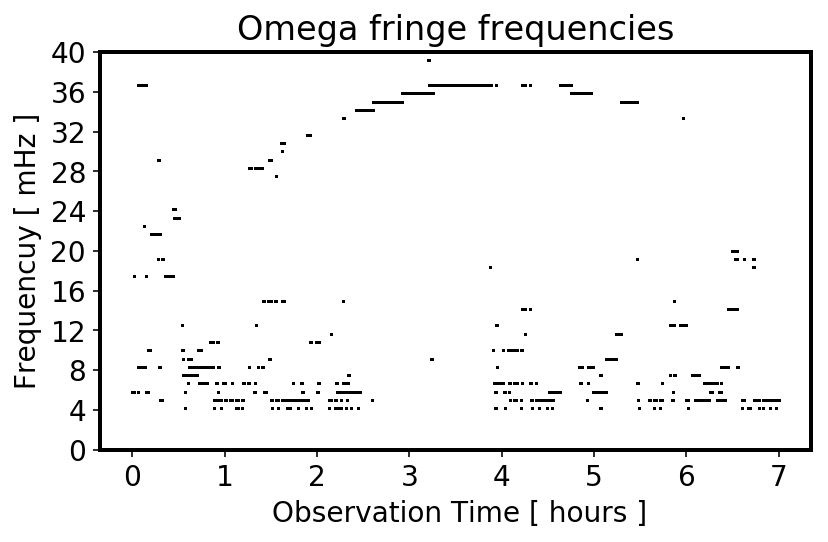

In [49]:
fig, ax = plt.subplots()
ax.plot(orion_fringe_freqs_actual, markersize = 0.5, color = 'black', marker = 's', ls = 'none')
ax.plot(orion_fringe_freqs_theory * 2 * np.pi / (24 * 60 * 60) , linewidth =1, color ='black')
ax.set_ylim(0, 0.04)

ytick_locations = np.linspace(0,0.04, 11)
ytick_labels = [str(int(x)) for x in  ytick_locations * 1000]
plt.yticks(ytick_locations, ytick_labels)
ax.set_ylabel(' Frequencuy [ mHz ] ')

xtick_locations = np.arange(0,len(orion_volts), 3600)
xtick_labels = [str(int(x)) for x in  xtick_locations / 3600]
ax.set_xticks(xtick_locations)
ax.set_xticklabels(xtick_labels)
ax.set_xlabel(' Observation Time [ hours ]')



ax.set_title('Omega fringe frequencies', y = 1)
plt.tight_layout()
plt.savefig('fringe.pdf', dpi = 1200)
plt.show()

In [50]:
data1 = np.load('sun_data(3).npz')


sun_volts = data1['volts'] - np.mean(data1['volts'])
sun_times = data1['times']

In [51]:
def ha_sun(time):
    
    '''
    This function calculates the hour angle for the sun data
    --------------------------------------------------------
    
    Parameters
    ------------
    
    time: unix time, this is the time returned in the data acquisition function
    
    Outputs
    ------------
    ha_: an array contianing the hour angle for the sun in radians
    '''
    
    ha_ = []
    for i in time:
        
        jd = ugradio.timing.julian_date(i)
        lst = ugradio.timing.lst(jd)
        ra, dec = ugradio.coord.sunpos(jd)
        
        h_s0 = lst - np.radians(ra)
        
        ha_.append(h_s0)
    
    return np.array(ha_)

def sun_declination(t):
    
    '''
    This function calculates the declination for the sun data
    --------------------------------------------------------
    
    Parameters
    ------------
    
    t: unix time, this is the time returned in the data acquisition function
    
    Outputs
    ------------
    dec: an array contianing the declination for the sun in radians
    '''
    dec = []
    
    for i in t:
        
        jday = ugradio.timing.julian_date(i)
        r, d = ugradio.coord.sunpos(jd=jday)
        
        dec.append(np.radians(d))
        
    return np.array(dec)

In [52]:
sun_decs = sun_declination(sun_times)
sun_ha = ha_sun(sun_times) + 2 * np.pi

In [53]:
len(sun_ha)

5069

In [54]:
sun_ha = sun_ha[300:]

#sun_ra = sun_ra[300:]


sun_volts = sun_volts[300:]
sun_times = sun_times[300:]

In [55]:
sun_times[0]

1552694552.928593

In [56]:
sun_plot_hour_angles_degrees = constrain_angle_to_one_circle((np.arange(0,165, 15) - 75) * u.deg).value

xticktop_value_ha = []
for number in sun_plot_hour_angles_degrees:
    xticktop_value_ha.extend([(min(sun_ha.value, key=lambda x:abs(x-number)))])
    
xticktop_locations_ha_indices = []
for value in xticktop_value_ha:
    xticktop_locations_ha_indices.extend(np.where(sun_ha.value == value)[0])

AttributeError: 'numpy.ndarray' object has no attribute 'value'

In [57]:
sun_plot_hour_angles_degrees

array([-75., -60., -45., -30., -15.,   0.,  15.,  30.,  45.,  60.,  75.])

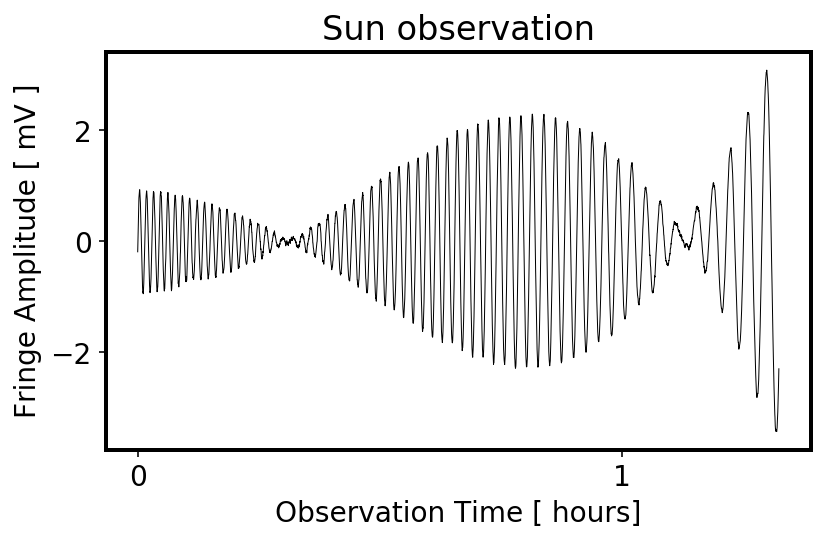

In [91]:
fig, ax = plt.subplots()
ax.plot(sun_times - sun_times[0], sun_volts * 1000 , linewidth = 0.5, color = 'black')
ax.set_ylabel('Fringe Amplitude [ mV ]')

xtick_locations = np.arange(0,len(sun_volts), 3600)
xtick_labels = [str(int(x)) for x in  xtick_locations / 3600]
ax.set_xticks(xtick_locations)
ax.set_xticklabels(xtick_labels)
ax.set_xlabel('Observation Time [ hours]')


ax.set_title('Sun observation', y = 1)
plt.tight_layout()
plt.savefig('sun.pdf', dpi = 1200)
plt.show()

In [92]:
sun_window_len = 1200 #seconds
sun_remainder = int(len(sun_volts) % sun_window_len)

sun_short_volts = sun_volts[:-sun_remainder]
sun_short_times = sun_volts[:-sun_remainder]

sun_VLA = np.zeros((len(sun_short_volts) - sun_window_len , sun_window_len))
for i in range(len(sun_short_volts) - sun_window_len):
    sun_window = sun_short_volts[i: sun_window_len + i]
    sun_VLA[i,:] = np.fft.fftshift(np.abs(np.fft.fft(sun_window*np.blackman(sun_window_len)))**2)
    sys.stdout.write('\r'+str('%d' %i ))

2399

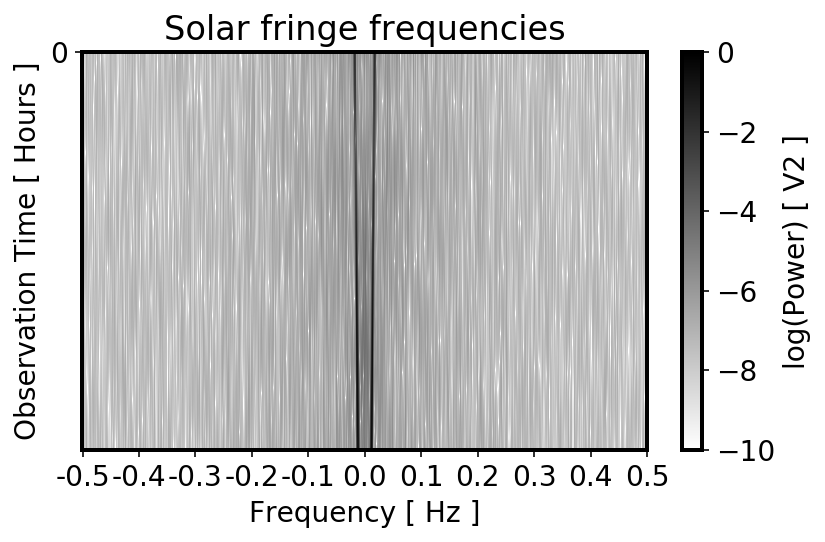

In [93]:
plt.imshow(np.log10(sun_VLA), aspect = 'auto',
           cmap = 'binary',
           interpolation='none',
           vmin = -10,
           vmax = 0)

ytick_locations = np.arange(0,sun_VLA.shape[0] + sun_window_len)[::sun_window_len][::3]
ytick_labels = [str(int(x)) for x in  np.arange(0,sun_VLA.shape[0] + sun_window_len)[::sun_window_len][::3] / 3600]
plt.yticks(ytick_locations, ytick_labels)
plt.ylabel('Observation Time [ Hours ]')

xtick_locations = np.arange(0,sun_window_len + sun_window_len/10)[::60][0::2]
freqs = np.round(np.fft.fftshift(np.fft.fftfreq(sun_window_len))[::60], decimals = 2)[0::2]
xtick_labels = np.append(freqs, abs(freqs[0]))
plt.xticks(xtick_locations, xtick_labels)
plt.xlabel('Frequency [ Hz ]')

cbar = plt.colorbar()
cbar.set_label('log(Power) [ V2 ]')
plt.title('Solar fringe frequencies')
plt.tight_layout()
plt.savefig('sun_fringe.pdf', dpi = 1200)
plt.show()

In [94]:
sun_peaksVLA = np.zeros((sun_VLA.shape[0], 2))
    
for i in range(sun_VLA.shape[0]):
    sys.stdout.write('\r'+str('%d' %i ))
    
    sun_threshold = 0
    num_peaks = 0
    while(num_peaks != 2):
        sun_threshold = sun_threshold -0.25
        peaks = peak_finder(np.log10(sun_VLA[i]), sun_threshold)
        num_peaks = len(peaks)
        
    sun_peaksVLA[i] = peaks

2399

In [95]:
sun_peak_indicies = np.array(sun_peaksVLA.T[1][:], dtype = int)
sun_freqs_range = np.fft.fftshift(np.fft.fftfreq(sun_window_len))
sun_fringe_freqs_actual = sun_freqs_range[sun_peak_indicies]

In [96]:
sun_fringe_freqs_theory = np.zeros(len(sun_fringe_freqs_actual))
for i in range(len(sun_fringe_freqs_actual)):
    sun_fringe_freqs_theory[i] = fringe_freqs(sun_ha[i], sun_decs[i])
    sys.stdout.write('\r'+str('%d' %i ))

TypeError: 'float' object is not callable

In [97]:
sun_fringe_freqs_theory_Hz = sun_fringe_freqs_theory * 2 * np.pi / (24 * 60 * 60)

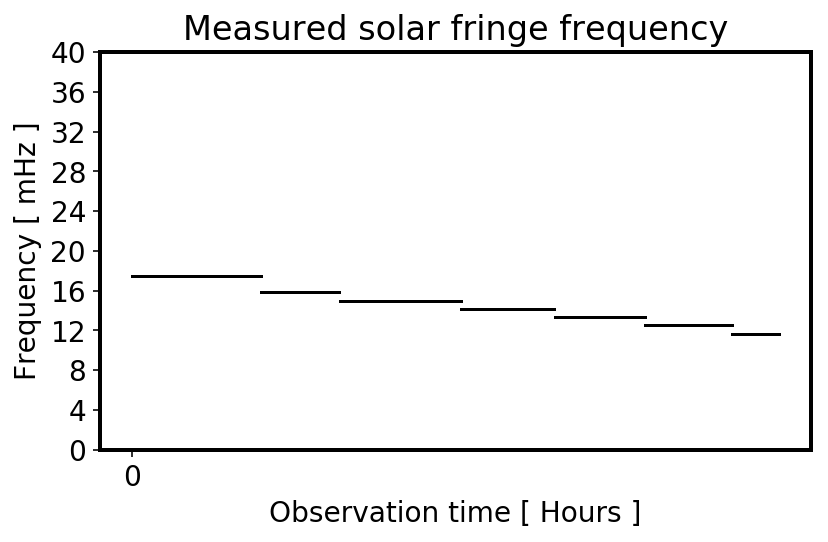

In [98]:
fig, ax = plt.subplots()
plt.plot(sun_fringe_freqs_actual, markersize = 0.5, marker = 's',linestyle = 'none', color = 'black')
plt.plot(sun_fringe_freqs_theory_Hz, linewidth = 0.75, linestyle = '--',color = 'black')
xtick_locations = np.arange(0,sun_VLA.shape[0] + sun_window_len)[::sun_window_len][::3]
xtick_labels = [str(int(x)) for x in  xtick_locations / 3600]





ax.set_xticks(xtick_locations)
ax.set_xticklabels(xtick_labels)
ax.set_xlabel('Observation time [ Hours ]')
ytick_locations = np.linspace(0,0.04, 11)
ytick_labels = [str(int(x)) for x in  ytick_locations * 1000]
plt.yticks(ytick_locations, ytick_labels)
plt.ylabel('Frequency [ mHz ]')

plt.title('Measured solar fringe frequency', y = 1)
plt.ylim(0)
plt.tight_layout()
plt.savefig('sun_freq.pdf', dpi = 1200)
plt.show()


In [99]:
sun_fringe_freqs_theory = np.zeros(len(sun_volts))
for i in range(len(sun_volts)):
    sun_fringe_freqs_theory[i] = fringe_freqs(sun_ha[i], sun_decs[i])
    sys.stdout.write('\r'+str('%d' %i ))

TypeError: 'float' object is not callable

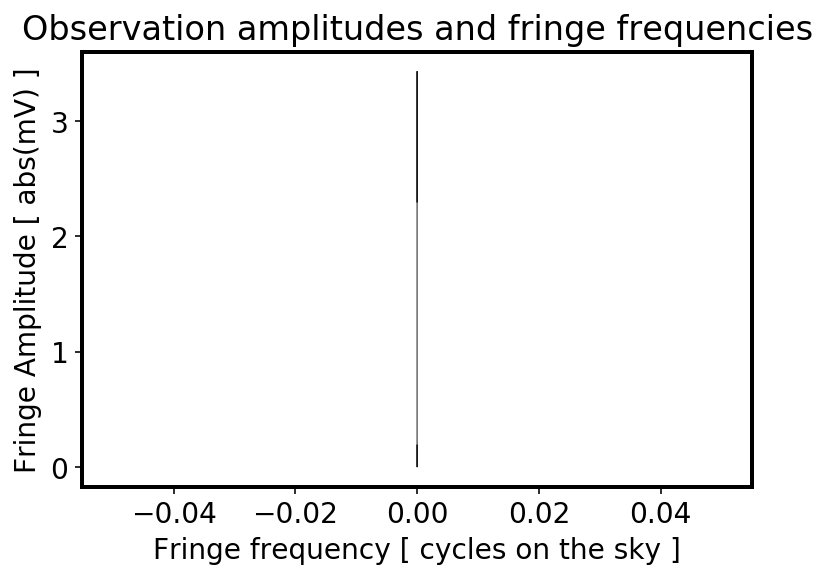

In [114]:
plt.plot(sun_fringe_freqs_theory, abs(sun_volts * 1000), linewidth = 0.5, alpha = 0.9, color = 'black')
plt.xlabel('Fringe frequency [ cycles on the sky ]')
plt.ylabel('Fringe Amplitude [ abs(mV) ]')
plt.title('Observation amplitudes and fringe frequencies')
plt.show()

[0.00000000e+00 5.45302013e-04 1.09060403e-03 ... 2.59890940e+00
 2.59945470e+00 2.60000000e+00]


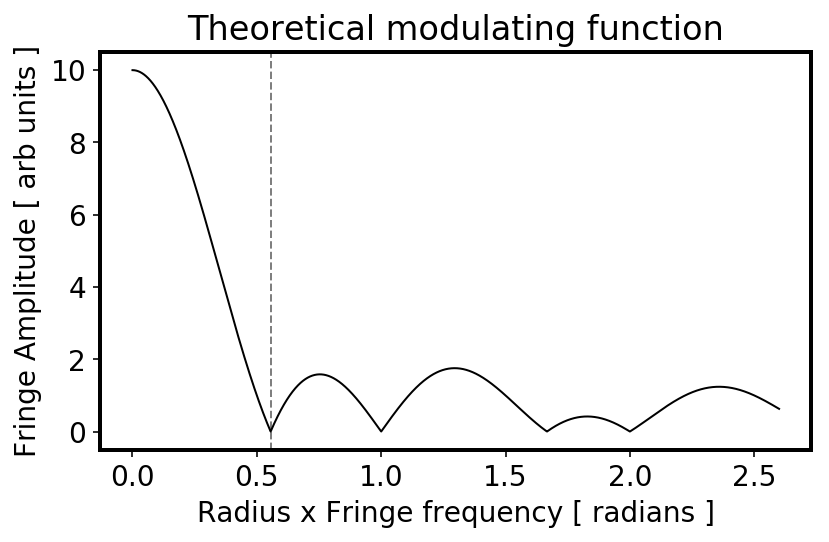

In [119]:
N = 10
Rf = np.linspace(0,2.6,num = len(sun_volts))
MF_theory = np.zeros(len(sun_volts))

for n in np.arange(-N,N,1):
    
    MF_theory += np.sqrt(1 - (n/N)**2 ) * np.cos(2 * np.pi * n * Rf/ N)
    
print(Rf)

plt.plot(Rf, abs(MF_theory), linewidth = 1, color = 'black')
plt.axvline(0.555, ls = '--', color = 'black', alpha = 0.5, linewidth = 1)
plt.xlabel('Radius x Fringe frequency [ radians ]')
plt.ylabel('Fringe Amplitude [ arb units ]')
plt.title('Theoretical modulating function')
plt.tight_layout()
plt.savefig('theoretical.pdf', dpi = 1200)
plt.show()

In [102]:
solar_diameter_radians = 2 * (0.615 / 124.5) * u.rad
solar_diameter_degrees = solar_diameter_radians.to(u.deg)
solar_diameter_meters = (np.sin(solar_diameter_degrees) * u.AU).to(u.m)
solar_diameter_kilometers = solar_diameter_meters.to(u.km)
solar_diameter_degrees

<Quantity 0.56605469 deg>

In [103]:
solar_true_diameter = 2 * c.R_sun

In [104]:
solar_diameter_degrees.to(u.rad)

<Quantity 0.00987952 rad>

In [105]:
solar_diameter_percent_error = 100 * (solar_diameter_meters - solar_true_diameter) / solar_true_diameter
solar_diameter_percent_error

<Quantity 6.21897547>

In [106]:
np.sin(solar_diameter_degrees)

<Quantity 0.00987936>

In [107]:
solar_diameter_radians

<Quantity 0.00987952 rad>